# BF vertex renormalization

Notebook for the analysis of BF vertex renormalization

## Setup

In [1]:
using CSV
using DataFrames
using HalfIntegers, JLD2, Distributions, Random
using LaTeXStrings

In [2]:
using Statistics
using StatsBase
using StatsPlots

In [3]:
theme(:default)
default(
    markerstrokewidth = 0,
    markerstrokealpha = 0,
    grid = :true,
    gridlinewidth = 0.5,
    fontfamily="Computer Modern",
    framestyle=:box,
    size=(800,300),
    margin=5Plots.mm
)
scalefontsizes(1.3)

# Decide how many monte carlo samples we take

We compare the results of MC sampling with $N_{mc}=1\,000$, $N_{mc}=10\,000$, $N_{mc}=100\,000$ samples. We compare with the exact result for the amplitude. 
We estimate the value of the Layers averaging over 20 trials and the error with the standard deviation. Then we sum the average value of the layers and we sum variances

In [4]:
BASE_DATA_DIRECTORY = "../../data";
function get_data(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_1.0/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

get_data (generic function with 1 method)

In [5]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(1000, trial).amp[id] - get_data(1000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc1K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc1K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

In [6]:
error_relative_Nmc1K = error_Nmc1K./amplitude_Nmc1K;

In [7]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(10000, trial).amp[id] - get_data(10000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc10K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc10K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

error_relative_Nmc10K = error_Nmc10K./amplitude_Nmc10K;

In [8]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(100000, trial).amp[id] - get_data(100000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc100K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

error_relative_Nmc100K = error_Nmc100K./amplitude_Nmc100K;

plot1 = Plot{Plots.GRBackend() n=3}


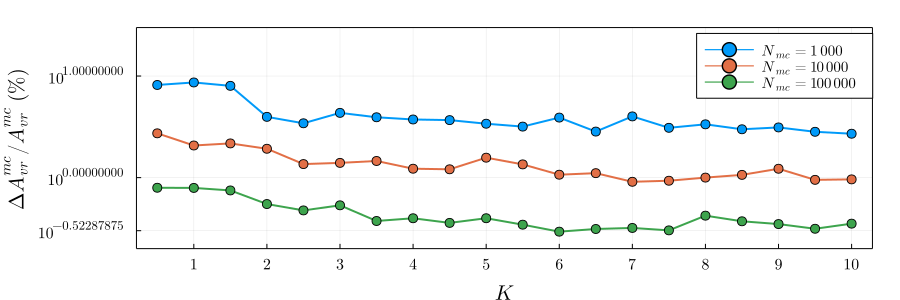

In [9]:
plot1 = plot(0.5:0.5:10,
               [100 .*error_relative_Nmc1K,100 .*error_relative_Nmc10K,100 .*error_relative_Nmc100K],
               label = [L"$N_{mc}=1\,000$" L"$N_{mc}=10\,000$" L"$N_{mc}=100\,000$"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.90),
               size = (900, 300),
               ylim = (0.2,30),
               yticks = [10, 1, 0.3],
               ylabel = L"\Delta A_{vr}^{mc}/A_{vr}^{mc}  \ (\%)",
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )

savefig(plot1,"./plots/BF/vertex_renormalization/relative_errors.svg")
savefig(plot1,"./plots/BF/vertex_renormalization/relative_errors.pdf")

@show plot1

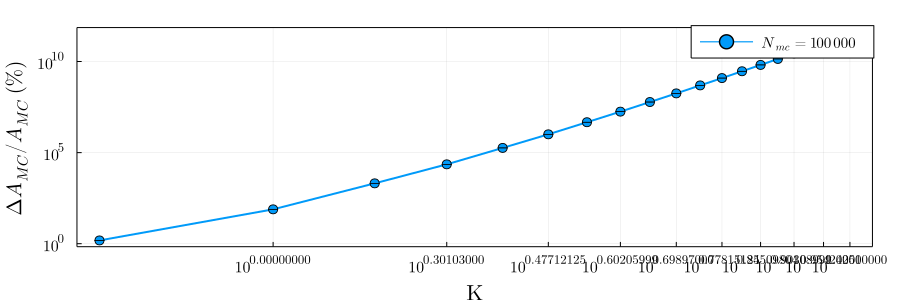

In [10]:
plot1 = plot(0.5:0.5:10,
               amplitude_Nmc100K,
               label = L"$N_{mc}=100\,000$",
               yscale=:log10,
               xscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.861,0.935),
               size = (900, 300),
               ylabel = L"\Delta A_{MC}/A_{MC} \ (\%)",
               xlabel = "K",
               yerror= error_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )

# Fitting the amplitude to find the scaling

We fit the amplitude as a function of the cutoff K using least squares fit. We use as a model the function 
$$ c_2K^{c_1} +  c_3 K^{c_1-1} +  c_4$$
and we perform the fit using only the last 10-ish points.

In [11]:
using LsqFit

In [12]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K[10:end], c0)
fit.param

3-element Vector{Float64}:
 11.202034596399333
  1.9119433508879375
  1.7049503518839835

In [13]:
margin_error(fit, 0.05)

3-element Vector{Float64}:
  0.6900350147336317
  4.389727226958819
 10.824261699217717

We cannot discriminate between $c_1=10$, $11$ or $12$. To circumvent this problem we look at the amplitudes with modified face amplitude 
$$ A_f(j_f) = (2j_f+1) \to (2j_f+1)^\mu$$
using as possible values of $\mu=0$, $\mu=0.1$, and $\mu=0.2$.

In [14]:
function get_data_mu0(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.0/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

get_data_mu0 (generic function with 1 method)

In [15]:
function get_data_mu01(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.1/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

get_data_mu01 (generic function with 1 method)

In [16]:
function get_data_mu02(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.2/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

get_data_mu02 (generic function with 1 method)

In [17]:
layers_trials_mu0 = DataFrame()
for trial in 1:20
    layers_trials_mu0[!,"$(trial)"]=[get_data_mu0(100000, trial).amp[id] - get_data_mu0(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu0 =  [mean(row) for row in eachrow(layers_trials_mu0)];
layers_variance_mu0 =  [var(row) for row in eachrow(layers_trials_mu0)];
amplitude_Nmc100K_mu0 = [sum(layers_average_mu0[1:id]) for id in 1:20];
error_Nmc100K_mu0 = sqrt.([sum(layers_variance_mu0[1:id]) for id in 1:20]);

In [18]:
layers_trials_mu01 = DataFrame()
for trial in 1:20
    layers_trials_mu01[!,"$(trial)"]=[get_data_mu01(100000, trial).amp[id] - get_data_mu01(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu01 =  [mean(row) for row in eachrow(layers_trials_mu01)];
layers_variance_mu01 =  [var(row) for row in eachrow(layers_trials_mu01)];
amplitude_Nmc100K_mu01 = [sum(layers_average_mu01[1:id]) for id in 1:20];
error_Nmc100K_mu01 = sqrt.([sum(layers_variance_mu01[1:id]) for id in 1:20]);

In [19]:
layers_trials_mu02 = DataFrame()
for trial in 1:20
    layers_trials_mu02[!,"$(trial)"]=[get_data_mu02(100000, trial).amp[id] - get_data_mu02(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu02 =  [mean(row) for row in eachrow(layers_trials_mu02)];
layers_variance_mu02 =  [var(row) for row in eachrow(layers_trials_mu02)];
amplitude_Nmc100K_mu02 = [sum(layers_average_mu02[1:id]) for id in 1:20];
error_Nmc100K_mu02 = sqrt.([sum(layers_variance_mu02[1:id]) for id in 1:20]);

The Monte Carlo approximation of the amplitude works well also in the case of modified $\mu$

We fit the amplitude with $\mu=0$

In [20]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu0[10:end], c0)
fit.param

3-element Vector{Float64}:
  1.9553200307405827
  0.17602084512367186
 -0.05395489236551573

In [21]:
margin_error(fit, 0.05)

3-element Vector{Float64}:
 0.016748753554953068
 0.00883779765381777
 0.023172110438455528

It is reasonable that the exponent is not exactly compatible with $4$ since we are just using an approximation for the scaling. 

In [22]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu01[10:end], c0)
fit.param

3-element Vector{Float64}:
 2.8892292514032643
 0.1514730413444437
 0.07243257767084368

In [23]:
margin_error(fit, 0.05)

3-element Vector{Float64}:
 0.020020109403276143
 0.00950142385163051
 0.0222654323229374

In [27]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu02[10:end], c0)
fit.param

3-element Vector{Float64}:
 4.0049712682432865
 0.08363926239755629
 0.2656980068203985

In [26]:
margin_error(fit, 0.05)

3-element Vector{Float64}:
 0.04702831839394576
 0.013763414799195873
 0.01854638313793415

# Repeat the analysis for the other boundary intertwiner

In [26]:
BASE_DATA_DIRECTORY = "../../data";
function get_data(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_1.0/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

get_data (generic function with 1 method)

In [27]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(1000, trial).amp[id] - get_data(1000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc1K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc1K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

error_relative_Nmc1K = error_Nmc1K./amplitude_Nmc1K;

layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(10000, trial).amp[id] - get_data(10000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc10K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc10K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

error_relative_Nmc10K = error_Nmc100K./amplitude_Nmc10K;

layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(100000, trial).amp[id] - get_data(100000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc100K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

error_relative_Nmc100K = error_Nmc100K./amplitude_Nmc100K;

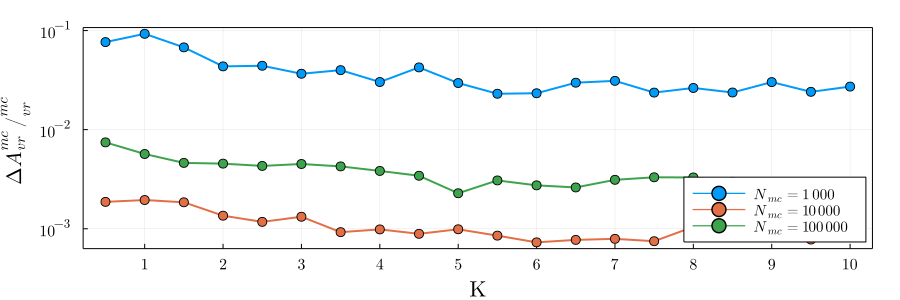

In [28]:
plot1 = plot(0.5:0.5:10,
               [abs.(error_relative_Nmc1K),abs.(error_relative_Nmc10K),abs.(error_relative_Nmc100K)],
               label = [L"$N_{mc}=1\,000$" L"$N_{mc}=10\,000$" L"$N_{mc}=100\,000$"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.25),
               size = (900, 300),
               ylabel = L"\Delta A^{mc}_{vr}/^{mc}_{vr}",
               xlabel = "K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )

In [29]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], abs.(amplitude_Nmc100K[10:end]), c0)
fit.param

4-element Vector{Float64}:
  10.898198117257525
  20.744633318784192
 -38.12590025091889
   9.632684409973232e8

In [30]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
   0.6148075222853449
  39.00572582916579
 150.60025035442794
   1.2545522232395597e9

In [31]:
function get_data_mu0(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.0/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end


function get_data_mu01(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.1/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_data_mu02(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.2/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end


layers_trials_mu0 = DataFrame()
for trial in 1:20
    layers_trials_mu0[!,"$(trial)"]=[get_data_mu0(100000, trial).amp[id] - get_data_mu0(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu0 =  [mean(row) for row in eachrow(layers_trials_mu0)];
layers_variance_mu0 =  [var(row) for row in eachrow(layers_trials_mu0)];
amplitude_Nmc100K_mu0 = [sum(layers_average_mu0[1:id]) for id in 1:20];
error_Nmc100K_mu0 = sqrt.([sum(layers_variance_mu0[1:id]) for id in 1:20]);


relative_error_Nmc100K_mu0 = error_Nmc100K_mu0./amplitude_Nmc100K_mu0;

layers_trials_mu01 = DataFrame()
for trial in 1:20
    layers_trials_mu01[!,"$(trial)"]=[get_data_mu01(100000, trial).amp[id] - get_data_mu01(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu01 =  [mean(row) for row in eachrow(layers_trials_mu01)];
layers_variance_mu01 =  [var(row) for row in eachrow(layers_trials_mu01)];
amplitude_Nmc100K_mu01 = [sum(layers_average_mu01[1:id]) for id in 1:20];
error_Nmc100K_mu01 = sqrt.([sum(layers_variance_mu01[1:id]) for id in 1:20]);


relative_error_Nmc100K_mu01 = error_Nmc100K_mu01./amplitude_Nmc100K_mu01;

layers_trials_mu02 = DataFrame()
for trial in 1:20
    layers_trials_mu02[!,"$(trial)"]=[get_data_mu02(100000, trial).amp[id] - get_data_mu02(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu02 =  [mean(row) for row in eachrow(layers_trials_mu02)];
layers_variance_mu02 =  [var(row) for row in eachrow(layers_trials_mu02)];
amplitude_Nmc100K_mu02 = [sum(layers_average_mu02[1:id]) for id in 1:20];
error_Nmc100K_mu02 = sqrt.([sum(layers_variance_mu02[1:id]) for id in 1:20]);


relative_error_Nmc100K_mu02 = error_Nmc100K_mu02./amplitude_Nmc100K_mu02;

In [32]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu0[10:end], c0)
fit.param

4-element Vector{Float64}:
  2.1923817516887345
 -0.298513066707331
 -1.1735412438076787
  2.6589487025382894

In [33]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.29751140625425704
 0.3335292502684432
 0.5674412783686705
 1.2342510665221424

In [34]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu01[10:end], c0)
fit.param

4-element Vector{Float64}:
  2.968520502788397
 -0.4716374033277675
 -0.6500823990740427
  1.359383927334665

In [35]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.0628517261395151
 0.10333548216972399
 0.2739159201951954
 1.5384078910841148

In [36]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu02[10:end], c0)
fit.param

4-element Vector{Float64}:
  4.124064417481754
 -0.21921431716101833
 -1.1926669884877892
  0.4108782007638786

In [37]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.3942393970135586
 0.33089281768765133
 0.24358384460232332
 7.965392461286203